# Capstone 2 - Identifying Cliff Problems

In this capstone exercise, you are tasked with finding problems that seem to be "cliffs".

We'll again be using information from the **correlated_answers** collection.

### We want to find out the number of students who attempt a problem and visualize that. This will visually show us "cliffs"

For example, if problem 1 is attempted by 15000 students and problem 2 is attempted by 600, one of those may be a cliff problem. Correlating that data with the previous capstone might be useful!

You'll also want to return information on the order of apperance of problems. You can find this information in the **course_info** collection.

## Tips

Here are a few tips

- The pipeline will look very similar to the last capstone. Rather than attempt information per student, we're interested in the students themselves this time.

- Getting an order of the problems will require a **$lookup** `from` **course_info**

- Within the inner pipeline of **$lookup**, the **`$map`** expression might prove very useful!

Again, the work of creating the visualization is done for you. Your job is to create an aggregation pipeline that produces output like the following, for each course.

## Required Output

```
[
  {
    "_id": "M036",
    "problems": [
      {
        "problem_id": "5a34333cdac97f48b78748ce",
        "users_attempted": 351
      },
      {
        "problem_id": "5a14c3bd7f87b5284fd81e36",
        "users_attempted": 347
      },
      ...,
    ],
    "problem_order": [
      {
        "chapters": [
          [
            "5a2192c1e433132c56d7ec55",
            "5a1dbcf98b0c765208f7e0c3"
          ],
          [
            "59c1a1c8f6bd8f33225d97c5",
            "59c2a1c8f6bd8f33225d97c7",
            "5ac1a1c8f6bd8f33225d97c9",
            "59c1a1c8f6bd8f33225d97cb",
            "5a0c882a0fa481129fcb408d"
          ],
          ...
        ]
      }
    ]
  },
  {
    "_id": "M001",
    ...
  },
  ...
]
```

In [1]:
# import our dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pymongo import MongoClient
client = MongoClient()
%matplotlib inline
from utils.workshop import *
#setup must be called prior to importing helpers
sns.set(font_scale=3)
correlated_answers = client.mdbw.correlated_answers

In [2]:
# create your stages here. Remember to iterate in small steps!
# Most of this pipeline is similar to the pipeline from capstone 1!

unwind_submissions = {
    "$unwind": "$submissions"
}

"""
We again group by problem and offering. Unlike the last capstone, rather than
figure out the average attempts, we $push the user_id into a field.

Why not $addToSet? If we used $addToSet we'd remove information about students
who took a course more than once.
"""
group_by_problem_and_offering = {
    "$group": {
        "_id": {
            "offering": {
                "$substrBytes": ["$_id.offering", 0, 4]
            },
            "problem": "$submissions.problem_id"
        },
        "users_attempted": {
            "$push": "$_id.user_id"
        }
    },
}

"""
Remapping from an array of user_id's to a number that is the size of that array
"""
get_users_attempted_size = {
    "$addFields": {
        "users_attempted": {"$size": "$users_attempted"}
    }
}

"""
Again grouping by offering and pushing the other information into the problems
field.
"""
group_by_offering = {
    "$group": {
        "_id": "$_id.offering",
        "problems": {
            "$push": {
                "problem_id": "$_id.problem",
                "users_attempted": "$users_attempted"
            }
        }
    }
}

"""
Up until now the problem is remarkably similar to the last capstone. Here, we
are using a lookup to get the problem ordering by chapter.

In the $project stage of the pipeline, we map over the $course.chapters array,
returning the value of the "url_name"s. These are the problem_ids.
"""
get_problem_order = {
    "$lookup": {
        "from": "course_info",
        "let": {"offering": "$_id"},
        "pipeline": [
            {
                "$match": {
                    "$expr": {
                        "$eq": [
                            "$$offering",
                            "$course.number"
                        ]
                    }
                }
            },
            {
                "$project": {
                    "_id": 0,
                    "chapters": {
                        "$map": {
                            "input": "$course.chapters",
                            "in": "$$this.lessons.problem.url_name"
                        }
                    }
                }
            },
        ],
        "as": "problem_order"
    }
}
pipeline = [unwind_submissions, group_by_problem_and_offering, get_users_attempted_size, group_by_offering, get_problem_order]

In [3]:
# ensure you suppled your stages to the aggregation variable above!
courses = list((correlated_answers.aggregate(pipeline)))
m_print(courses)
# making a copy of the original results
results = courses[:]

[
  {
    "_id": "M036",
    "problems": [
      {
        "problem_id": "5a34333cdac97f48b78748ce",
        "users_attempted": 351
      },
      {
        "problem_id": "5a14c3bd7f87b5284fd81e36",
        "users_attempted": 347
      },
      {
        "problem_id": "5a31a4f90fa481306b858192",
        "users_attempted": 352
      },
      {
        "problem_id": "5a4fc55ae433130c6c17ed80",
        "users_attempted": 275
      },
      {
        "problem_id": "59ef3c21e43313130dda32a2",
        "users_attempted": 819
      },
      {
        "problem_id": "5a34333cdac97f48b78748df",
        "users_attempted": 326
      },
      {
        "problem_id": "5a34333cdac97f48b78748bd",
        "users_attempted": 335
      },
      {
        "problem_id": "5a5289a09237ae699f4f2ecc",
        "users_attempted": 264
      },
      {
        "problem_id": "5a4fafabe43313fdf585c2c5",
        "users_attempted": 279
      },
      {
        "problem_id": "59e115a30a8a1bbcae228a13",
        "users_at

# Finished?
Run the following cells without modifying them and you should see each course as a plot, with each problem graphed in the order they appear in the course.

In [4]:
problem_orders = [{"course": course["_id"]} for course in results]

def find_ordering_index(course):
    """
    Finds the order of a course in the results
    """
    return next((index for (index, d) in enumerate(problem_orders) if d['course'] == course))

def get_chapter_and_ordering(course, problem_id):
    """
    Gets the chapter and position in the chapter a particular problem is in
    """
    problem_order = results[find_ordering_index(course)]['problem_order'][0]['chapters']
    for (ix, chapter) in enumerate(problem_order):
        if problem_id in chapter:
            return (ix, chapter.index(problem_id))

def translate_to_object(course, d):
    """
    Translates a problem in the results to the format we want for graphing
    """
    chapter, order = get_chapter_and_ordering(course, d["problem_id"])
    return {
        "problem": d["problem_id"],
        "users_attempted": d["users_attempted"],
        "chapter": chapter,
        "order": order
    }    


# Visualizing

Once you've peformed the necessary transformation, run the following cell to show a nice graph of the "noise" in problem attempts.

While we called these "Problem problems" we should be suspicious. Is the average number of attempts per problem a good indicator?

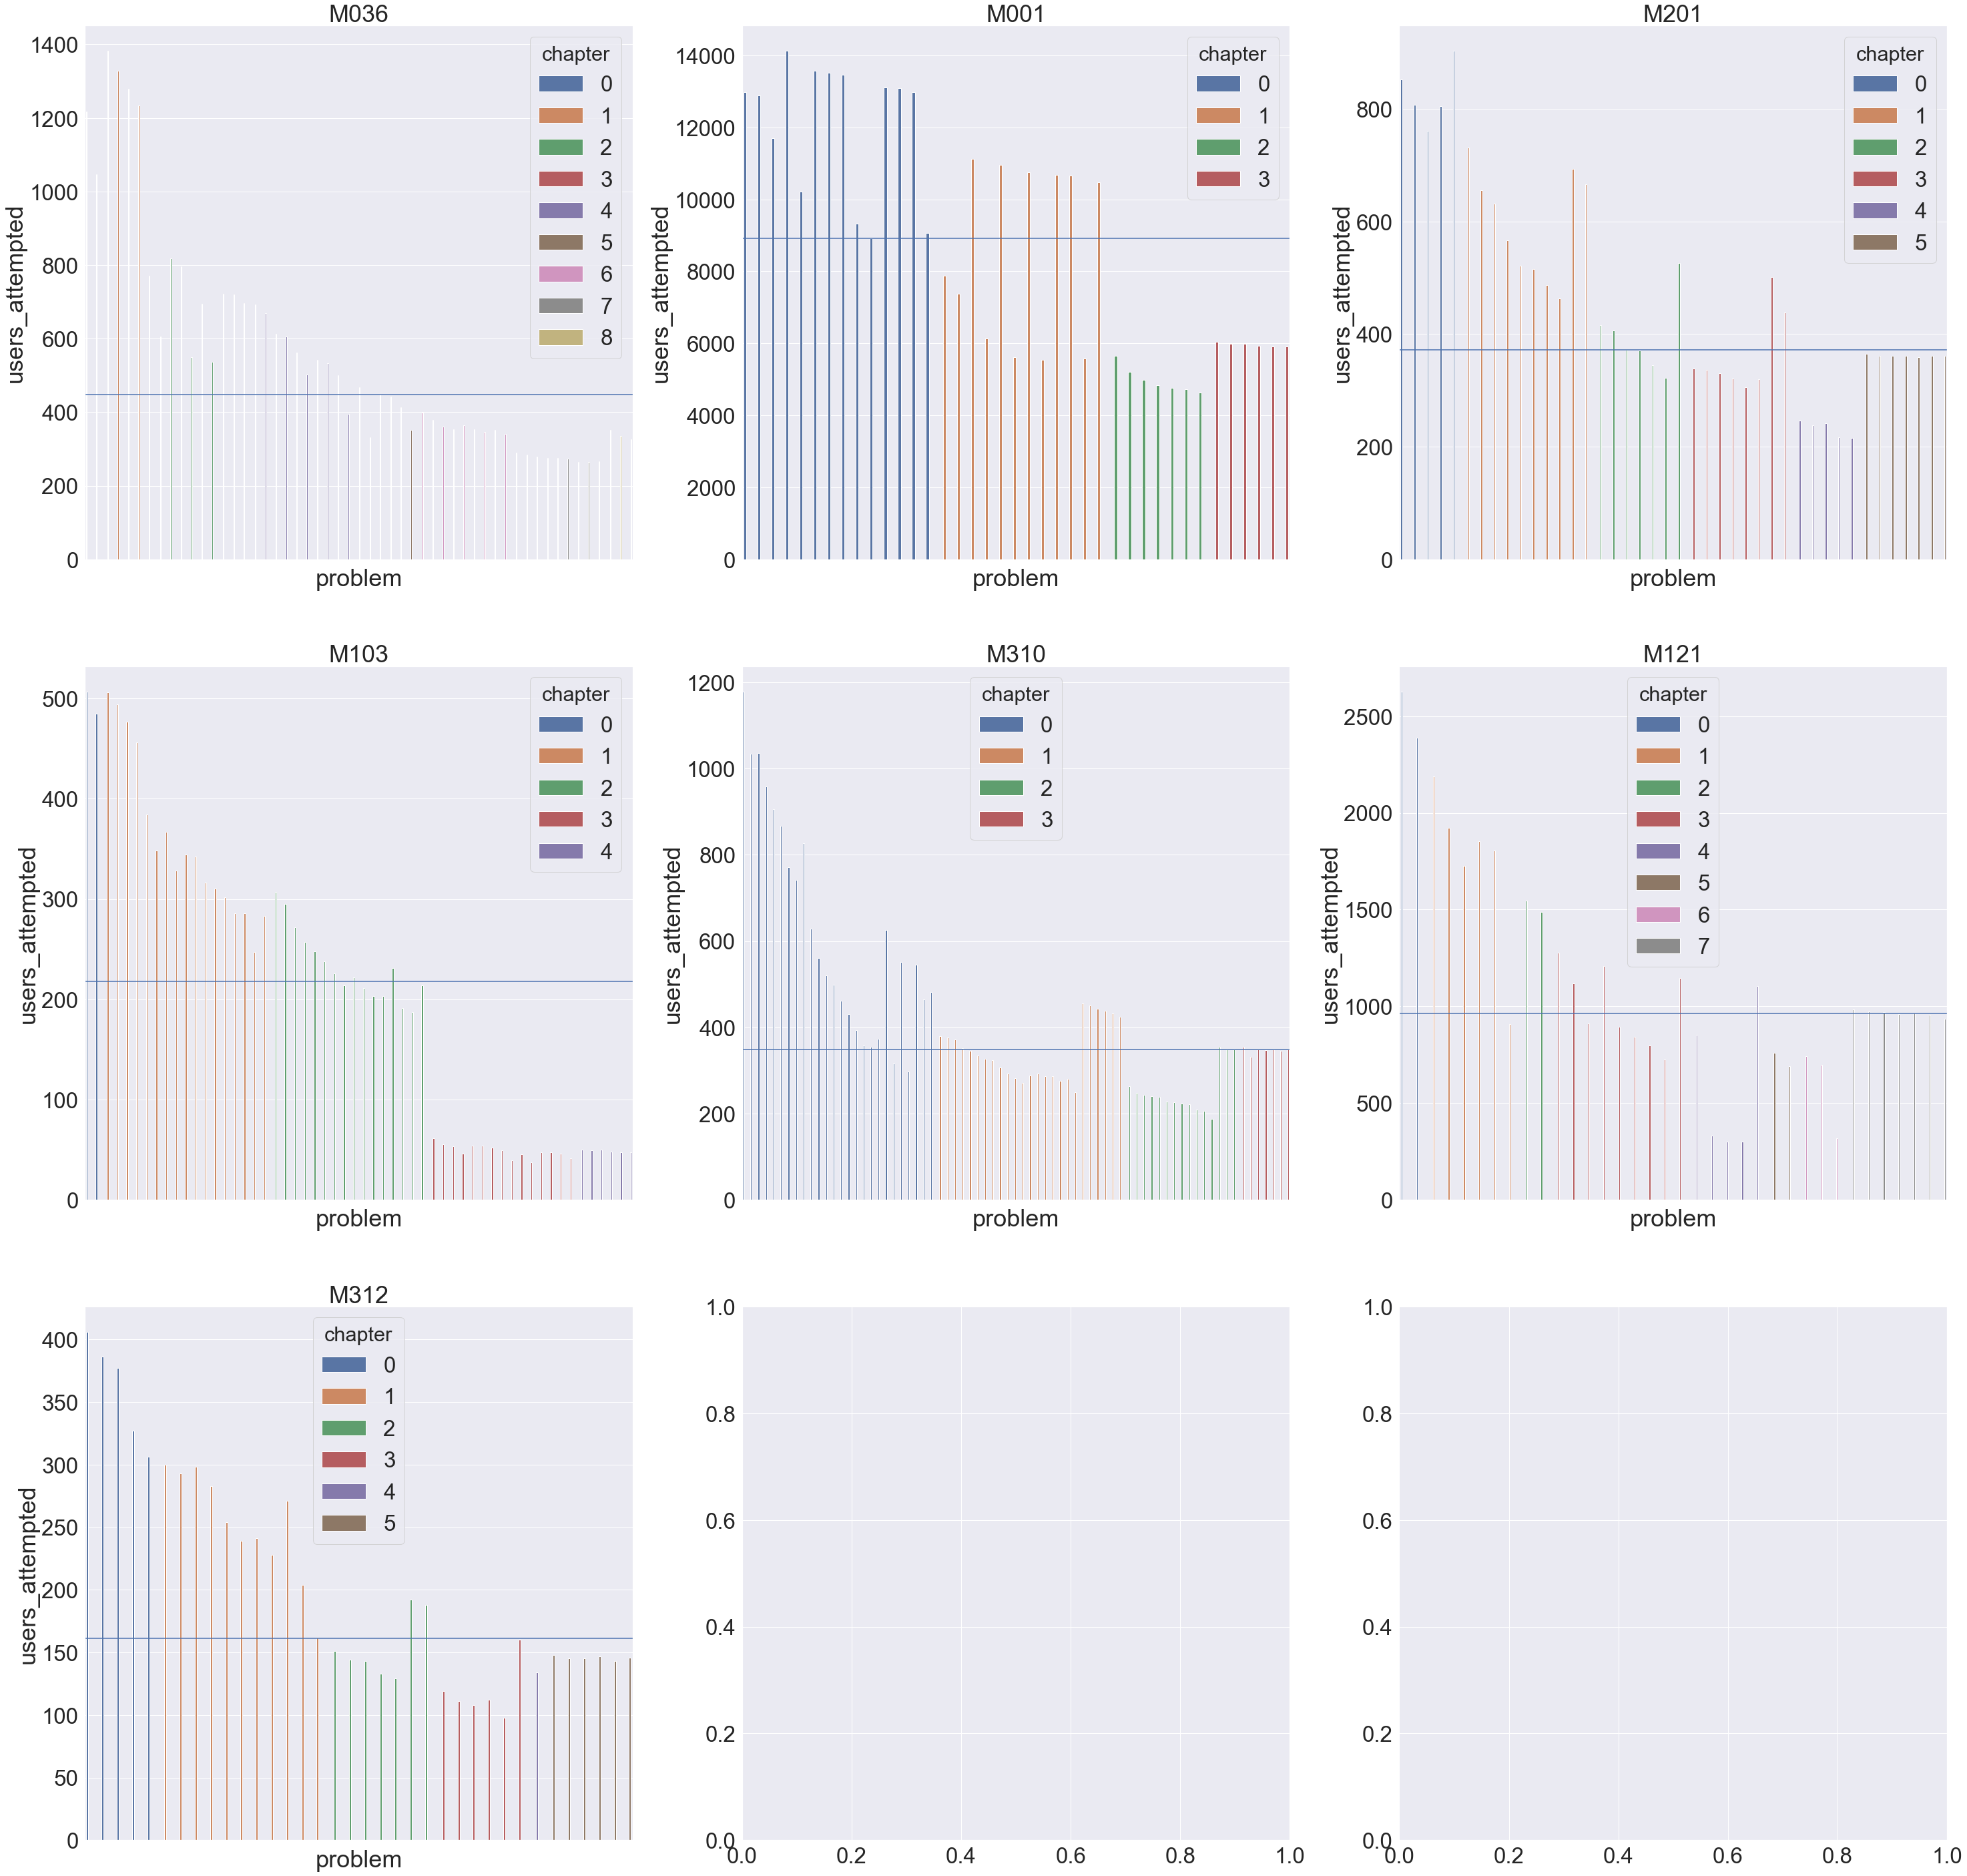

In [5]:
"""
Creating the dataframe again
"""
import operator
df = pd.DataFrame([
    {
        "course": course['_id'], 
        "problems": pd.DataFrame(
            sorted([translate_to_object(course['_id'], p) for p in course["problems"]], key=operator.itemgetter('chapter','order'))
        )
    } for course in results])

fig, axs = plt.subplots(ncols=3, nrows=3,figsize=(50, 50))
courses = df['course'].tolist()
x = 0
for course in df['course']:
    bp = sns.barplot(
        x="problem", 
        y="users_attempted",
        hue="chapter",
        data=df['problems'][courses.index(course)], 
        ax=axs[x//3, x%3],
    ).set_title(course)
    axes = bp.axes
    ymed = df['problems'][courses.index(course)]['users_attempted'].median()
    axes.axhline(y=ymed, xmin=0, xmax=1)
    axes.set_xticklabels([])
    x+=1

# Interpretation
Some clearly identifiable patterns are emerging. There is some variance, which we expect. Perhaps some of them are "labs" that count towards a student's grade. It loks like the final questions - the questions in the last chapter - all hover around the same values.

Looking at the difference between the start of a course and the end of a course, we can definitely see some dropoff. The nature of free courses! However, there are clearly visible dropoff points.

In [7]:
df = pd.DataFrame.from_dict(list(correlated_answers.find()))

In [10]:
df['submissions'][0]

[{'attempts': [{'correct': True, 'indices': [0, 1, 2]}],
  'num_attempts': 1,
  'problem_id': '594d88bbbb7efccf98a5cd23'},
 {'attempts': [{'correct': True, 'indices': [1, 2]}],
  'num_attempts': 1,
  'problem_id': '5963b30cc1da5a32116dc5b7'},
 {'attempts': [{'correct': False, 'indices': [0, 1, 4]},
   {'correct': True, 'indices': [0, 1, 2, 4]}],
  'num_attempts': 2,
  'problem_id': '594f8df6eb611cafa52e291e'},
 {'attempts': [{'correct': False, 'indices': [0, 1, 3, 4, 5, 6]},
   {'correct': True, 'indices': [0, 1, 3, 4, 6]}],
  'num_attempts': 2,
  'problem_id': '5950fb4ab0833b655d93edfe'},
 {'attempts': [{'correct': True, 'indices': [0, 1]}],
  'num_attempts': 1,
  'problem_id': '594fb33a57106a5740829c17'},
 {'attempts': [{'correct': False, 'indices': [0, 1, 2, 3, 4, 7, 9]}],
  'num_attempts': 1,
  'problem_id': '5950158377e77e5813f1d0f7'}]